# Initialize model

In [1]:
msmt_err_dict = {
    0: {'p_soft': 0.0, 'p_hard': 0.0},
    1: {'p_soft': 0.0, 'p_hard': 0.00},
    2: {'p_soft': 0.0, 'p_hard': 0.0},
    3: {'p_soft': 0.0, 'p_hard': 0.00},
    4: {'p_soft': 0.0, 'p_hard': 0.00},
}

msmt_err_dict = {
    0: {'p_soft': 0.0, 'p_hard': 0.09},
    1: {'p_soft': 0.18, 'p_hard': 0.19},
    2: {'p_soft': 0.28, 'p_hard': 0.29},
    3: {'p_soft': 0.38, 'p_hard': 0.39},
    4: {'p_soft': 0.48, 'p_hard': 0.49},
}


p_soft_mean = 0.005
p_hard_mean = 0.005

In [7]:
from soft_info import RepetitionCodeStimCircuit

D = 3
T = 2
RESETS = False
LOGICAL = '0'
XBASIS = False

SUBSAMPLING = False
NO_FIN_SOFT = False

LAYOUT = [1, 3, 0, 2, 4]
NOISE_LIST = [3e-2, 1e-3, 0.2e-2, 0.2e-2, p_hard_mean+p_soft_mean, p_hard_mean, p_soft_mean]

code = RepetitionCodeStimCircuit(D, T, XBASIS, RESETS, NOISE_LIST,
                                 subsampling=SUBSAMPLING, no_fin_soft=NO_FIN_SOFT,
                                #  layout=LAYOUT, msmt_err_dict=msmt_err_dict)
                                 layout=None, msmt_err_dict=None)
circ = code.circuits[LOGICAL]

model = circ.detector_error_model()

# countMat & pSoft

In [8]:
import numpy as np

countMat = np.array([
    [0,0,0,0,0,0,0], # no errors
    [1,0,1,0,0,0,1], # 1 msmt + 1 logical error
    [0,0,0,0,0,0,0], 
    [0,0,0,0,0,0,0], 
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    ])

pSoft = np.array([
    [1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2],
    [0.5,0.5,0.5,0.5,0.5,0.5,0.5], 
    [0,0,0,0,0,0,0], 
    [0,0,0,0,0,0,0], 
    [1e-8,1e-8,1e-8,1e-8,1e-8,1e-8,1e-8],
    [0.5,0.5,0.5,0.5,0.5,0.5,0.5], 
    [1e-8,1e-8,1e-8,1e-8,1e-8,1e-8,1e-8],
    [1e-80, 1e-80, 1e-80, 1e-80, 1e-80, 1e-80, 1e-80],
    [0,0,0,0,0,0,0.5],
    [0,0.5,0,0,0,0,0],
    ])


# check that the dimensions are the same
assert countMat.shape == pSoft.shape, f"countMat.shape = {countMat.shape}, pSoft.shape = {pSoft.shape}"

# Check reweighting


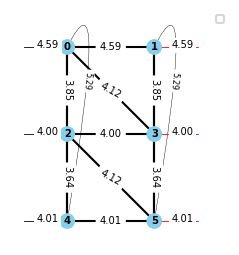

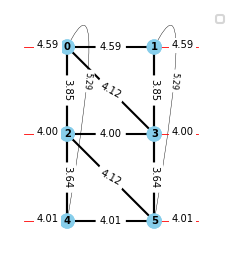

In [21]:
from soft_info import draw_matching_graph  
import cpp_soft_info as cpp 
import pymatching

DECODE_HARD = True

result = cpp.decodeConvertorAll(model, countMat, pSoft, T, int(LOGICAL), RESETS, _detailed=True, decode_hard=DECODE_HARD)

SHOT = 1
matching2 = pymatching.Matching.from_detector_error_model(model)
result_edges = []
for edge in result.error_details[SHOT].edges:
    node1, node2, w = edge.node1, edge.node2, edge.attributes.weight
    if node2 == 18446744073709551615: 
        matching2.add_boundary_edge(node1, {0}, w, 0, merge_strategy='replace')
    else:
        matching2.add_edge(node1, node2, {0}, w, 0, merge_strategy='replace')
matching = pymatching.Matching.from_detector_error_model(model)
draw_matching_graph(matching, D, T, figsize=(1.5,1.5), scale_factor=0.4)
draw_matching_graph(matching2, D, T, figsize=(1.5,1.5), scale_factor=0.4)


In [5]:
for edge in result.error_details[SHOT].edges:
    print(f"Edge ({edge.node1}, {edge.node2}): w:{edge.attributes.weight:.2f}, p:{edge.attributes.error_probability:.2f}, f:{edge.attributes.fault_ids}")
    

Edge (0, 18446744073709551615): w:4.59, p:0.01, f:set()
Edge (0, 1): w:4.59, p:0.01, f:set()
Edge (0, 2): w:1.39, p:0.20, f:set()
Edge (0, 3): w:4.12, p:0.02, f:set()
Edge (0, 4): w:4.60, p:0.01, f:set()
Edge (1, 3): w:0.43, p:0.39, f:set()
Edge (1, 5): w:4.60, p:0.01, f:set()
Edge (1, 18446744073709551615): w:4.59, p:0.01, f:{0}
Edge (2, 18446744073709551615): w:4.00, p:0.02, f:set()
Edge (2, 3): w:4.00, p:0.02, f:set()
Edge (2, 4): w:0.79, p:0.31, f:set()
Edge (2, 5): w:4.12, p:0.02, f:set()
Edge (3, 5): w:0.10, p:0.47, f:set()
Edge (3, 18446744073709551615): w:4.00, p:0.02, f:{0}
Edge (4, 18446744073709551615): w:2.15, p:0.10, f:set()
Edge (4, 5): w:0.36, p:0.41, f:set()
Edge (5, 18446744073709551615): w:0.00, p:0.50, f:{0}


# Check decoding

In [6]:
for details in result.error_details:
    print(details.matched_edges)

[]
[(4, 0), (4, 2), (5, -1)]
[]
[]
[]
[]
[]
[]
[]
[]
